# Hierarchical ARHMM Demo

This notebook illustrates the use of the _hierarchical_ar_ observation model.  This model makes use of the `tags` argument to distinguish between different groups of data.  Groups are assumed to follow similar switching linear dynamics, but the parameters need not be exactly the same.

Let $x_t^{(i)}$ denote the observation at time $t$ in the $i$-th dataset.  Let $z_t^{(i)}$ denote the corresponding discrete state, and let $g_i$ denote the _group_ to which that dataset belongs.  The groups are identified by `tags` in the code. 

The hierarchical autoregressive hidden Markov model has the following likelihood,
$$
\begin{align}
x_t^{(i)} \mid x_{t-1}^{(i)}, z_t^{(i)}, g_i &\sim
\mathcal{N}\left(A_{z_t}^{(i)} x_{t-1}^{(i)} + b_{z_t}^{(i)}, Q_{z_t}^{(i)} \right).
\end{align}
$$
(Technically, higher-order autoregressive processes with extra linear terms from inputs are also implemented.) 

The _hierarchical_ component of the model is in the prior distribution on the parameters.  We assume that each group's parameters are a noisy perturbation around a global mean,
$$
\begin{align}
\mathrm{vec}(A_k^{(i)}) &\sim \mathcal{N} \left(\mathrm{vec}(A_k), \sigma_A^2 I \right) \\
b_k^{(i)} &\sim \mathcal{N} \left(b_k, \sigma_b^2 I \right).
\end{align}
$$
For the covariance matrices, we assume an inverse Wishart prior
$$
\begin{align}
Q_k^{(i)} &\sim \mathrm{IW}(\nu + d + 1, \nu Q_k),
\end{align}
$$
which has mean
$$
\begin{align}
\mathbb{E}[Q_k^{(i)}] &= \frac{\nu Q_k}{(\nu + d + 1) - d - 1} = Q_k.
\end{align}
$$
As the "extra" degrees of freedom $\nu$ goes to zero, the variance of the per-group covariance matrices $Q_k^{(i)}$ increases. 

We fit the hierarchical ARHMM model with EM, and in the M-step we perform an alternating optimization of the per-group parameters and the global parameters.

In [1]:
%load_ext autoreload
%autoreload 2

In [78]:
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [7]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation
lags = 1          # number of lags in the AR model

# Specify tags for the hierarchical AR model
unique_tags = ["matt", "scott"]

# Make an HMM
true_harhmm = ssm.HMM(num_states, obs_dim, 
                      observations="hierarchical_ar", 
                      observation_kwargs=dict(lags=lags, tags=unique_tags))

# Plot dynamics functions for the two groups (tags)

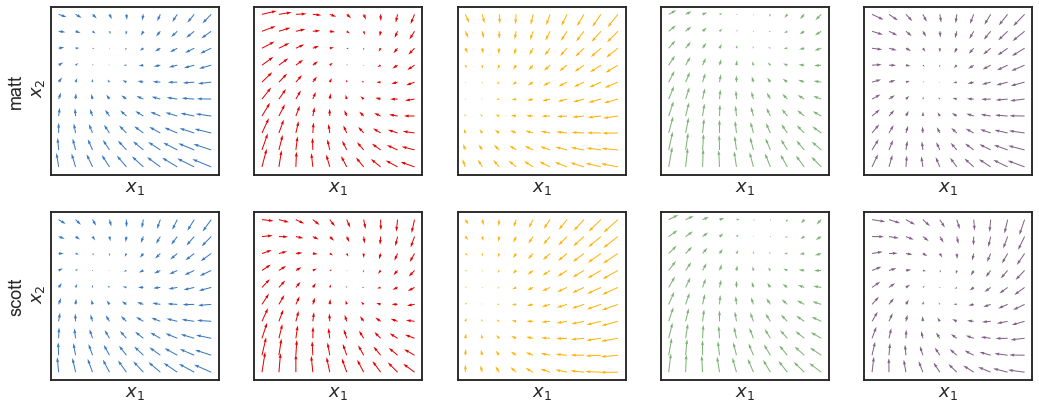

In [8]:
x = np.linspace(-8, 8, 10)
y = np.linspace(-8, 8, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

fig, axs = plt.subplots(len(unique_tags), num_states, figsize=(3 * num_states, 6))
for i, tag in enumerate(unique_tags):
    for k, (A, b) in enumerate(zip(
        true_harhmm.observations.per_group_ar_models[i].As, 
        true_harhmm.observations.per_group_ar_models[i].bs)):
        
        dxydt_m = xy.dot(A.T) + b - xy
        axs[i, k].quiver(xy[:, 0], xy[:, 1],
                  dxydt_m[:, 0], dxydt_m[:, 1],
                  color=colors[k % len(colors)])

        
        axs[i,k].set_xlabel('$x_1$')
        axs[i,k].set_xticks([])
#         axs[i,k].set_ylabel('$x_2$')
        if k == 0:
            axs[i,k].set_ylabel(tag + "\n $x_2$")
        axs[i,k].set_yticks([])
        axs[i,k].set_aspect("equal")
                    

plt.tight_layout()

# Sample data from the hierarchical ARHMM

In [9]:
# Sample some data from the HMM
tags = unique_tags * 5
true_states, datas = list(zip(*[true_harhmm.sample(time_bins, tag=tag) for tag in tags]))
true_lp = true_harhmm.log_probability(datas, tags=tags)

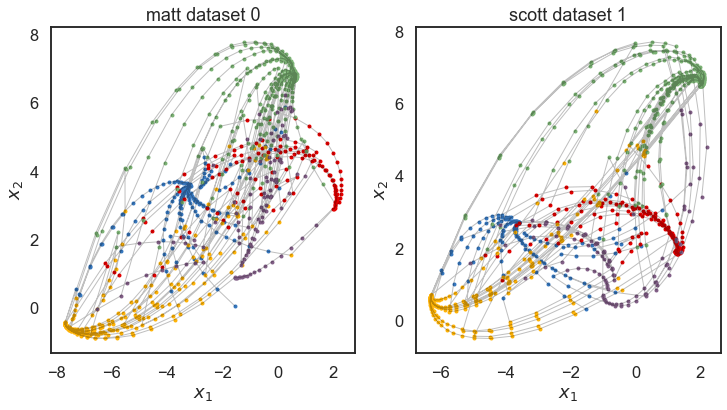

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for idx, ax in enumerate(axs):
    zs = true_states[idx]
    for k in range(num_states):
        ax.plot(datas[idx][true_states[idx]==k, 0], 
                datas[idx][true_states[idx]==k, 1], 
                'o', mfc=colors[k], mec='none', ms=4)

    ax.plot(datas[idx][:,0], datas[idx][:,1], '-k', lw=1, alpha=.25)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(tags[idx] + " dataset " + str(idx % 2))

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

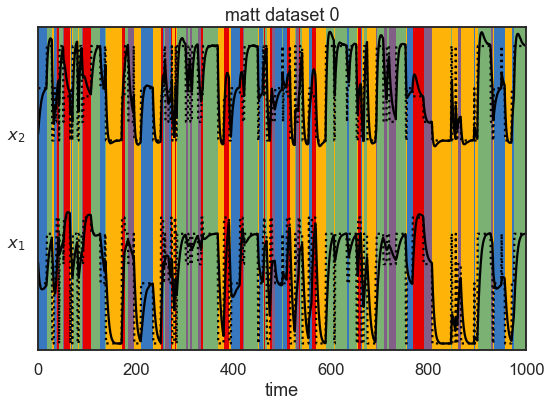

In [11]:
# Compute the stationary point for each AR model
assert lags == 1
idx = 0
As = true_harhmm.observations.get_As(tags[idx])
bs = true_harhmm.observations.get_bs(tags[idx])
mus = np.linalg.solve(np.eye(obs_dim) - As, bs)

# Plot the data and the smoothed data
lim = 1.05 * abs(datas[idx]).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[idx][None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))


Ey = mus[true_states[idx]]
for d in range(obs_dim):
    plt.plot(datas[idx][:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title(tags[idx] + " dataset " + str(idx % 2))

plt.tight_layout()


# Fit a regular ARHMM to all the data (ignoring tags)

In [22]:
def fit_with_random_restarts(make_model,
                             num_restarts=5,
                             num_iters=1000,
                             method="em",
                             tolerance=1e-4,
                             **kwargs):

    all_models = []
    all_lps = []

    # Fit the model with a few random restarts
    for r in range(num_restarts):
        print("Restart ", r)
        model = make_model()
        lps = model.fit(datas, tags=tags,
                        method=method, 
                        num_iters=num_iters,
                        tolerance=tolerance,
                        **kwargs)
        all_models.append(model)
        all_lps.append(lps)

    best_model_idx = np.argmax([lps[-1] for lps in all_lps])
    best_model = all_models[idx]
    
    return best_model, all_models, all_lps

In [13]:
make_arhmm = lambda: ssm.HMM(num_states, obs_dim, 
                             observations="ar",
                             observation_kwargs=dict(lags=lags))

reg_arhmm, all_reg_arhmms, all_reg_arhmm_lps = fit_with_random_restarts(make_arhmm)

Restart  0



Restart  1



Restart  2



Restart  3



Restart  4


Text(0.5, 1.0, 'Regular ARHMM Training Curves')

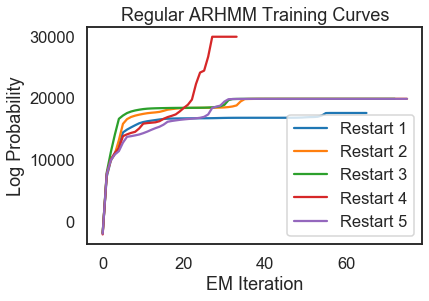

In [14]:
for r, reg_arhmm_lps in enumerate(all_reg_arhmm_lps):
    plt.plot(reg_arhmm_lps, label="Restart {}".format(r+1))
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.title("Regular ARHMM Training Curves")

# Fit a hierarchical ARHMM to all the data with batch EM (using tag info)

Batch EM performs the following updates for each EM iteration:
1. Compute expectations for each set of data under appropriate group model
2. Maximize likelihood of each group model using group-specific expectations (includes a prior)
3. Update global model by averaging over group model parameters
4. Update the global prior

In [15]:
make_harhmm = lambda: ssm.HMM(num_states, obs_dim, 
                              observations="hierarchical_ar",
                              observation_kwargs=dict(lags=lags, tags=unique_tags))

harhmm, all_harhmms, all_harhmm_lps = fit_with_random_restarts(make_harhmm)

Restart  0


Restart  1


Restart  2


Restart  3


Restart  4


Text(0.5, 1.0, 'Hierarchical ARHMM (BEM) Training Curves')

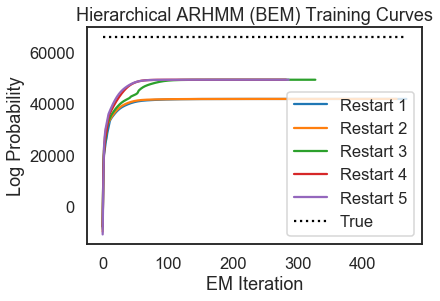

In [16]:
for r, harhmm_lps in enumerate(all_harhmm_lps):
    plt.plot(harhmm_lps, label="Restart {}".format(r+1))
plt.plot([0, max(map(len, all_harhmm_lps))], 
         true_harhmm.log_probability(datas, tags=tags) * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.title("Hierarchical ARHMM (BEM) Training Curves")

# Fit a hierarchical ARHMM to all the data with stochastic EM (using tag info)

Stochastic EM performs the following updates:
1. Grab a random batch of data from group $g$
2. Compute expectations
3. Compute expected sufficient statistics (ESS)
4. Take a convex combo of current ESS and a running average
5. Maximize likelihood of group $g$ params using averaged sufficient stats

In [79]:
num_epochs = 400
harhmm_sem, all_harhmms_sem, all_harhmm_sem_lps = fit_with_random_restarts(
    make_harhmm, method='stochastic_em_conj', num_epochs=num_epochs)

Restart  0


Restart  1


Restart  2


Restart  3


Restart  4


Text(0.5, 1.0, 'Hierarchical ARHMM (SEM) Training Curves')

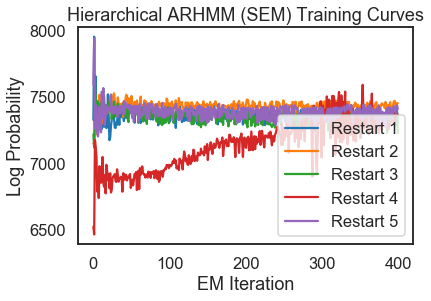

In [80]:
for r, harhmm_lps in enumerate(all_harhmm_sem_lps):
    plt.plot(harhmm_lps[0], label="Restart {}".format(r+1))
# plt.plot([0, num_epochs], 
#          true_harhmm.log_probability(datas, tags=tags) * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.title("Hierarchical ARHMM (SEM) Training Curves")

Text(0.5, 1.0, 'Hierarchical ARHMM (SEM) Training Curves')

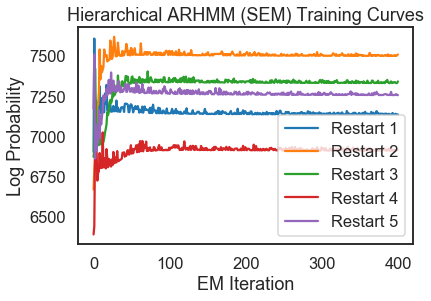

In [36]:
for r, harhmm_lps in enumerate(all_harhmm_sem_lps):
    plt.plot(harhmm_lps[0], label="Restart {}".format(r+1))
# plt.plot([0, num_epochs], 
#          true_harhmm.log_probability(datas, tags=tags) * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.title("Hierarchical ARHMM (SEM) Training Curves")

In [99]:
inputs = [np.zeros((data.shape[0],) + (0,)) for data in datas]
masks = [np.ones_like(data, dtype=bool) for data in datas]
# a = harhmm_sem.log_likelihood(datas, inputs, masks, tags)
# b = harhmm.log_likelihood(datas, inputs, masks, tags)
a = harhmm_sem.log_probability(datas, inputs, masks, tags)
b = harhmm.log_probability(datas, inputs, masks, tags)
print(a)
print(b)

7452.746283033292
16918.455558628375


In [100]:
print(harhmm.log_likelihood(datas[i], inputs[i], masks[i], tags[i]))

pi0 = harhmm.init_state_distn.initial_state_distn
Ps = harhmm.transitions.transition_matrices(datas[i], inputs[i], masks[i], tags[i])
log_likes = harhmm.observations.log_likelihoods(datas[i], inputs[i], masks[i], tags[i])

3665.1697138315453


In [91]:
pi0

array([0.4487742 , 0.19974689, 0.07972548, 0.07232793, 0.1994255 ])

In [92]:
Ps

array([[[0.85690063, 0.03158251, 0.05022096, 0.03312533, 0.02817056],
        [0.02664073, 0.87914205, 0.01949322, 0.04548418, 0.02923983],
        [0.02720721, 0.02301773, 0.8929421 , 0.04484276, 0.01199019],
        [0.02680965, 0.00200965, 0.01876676, 0.90985255, 0.0425614 ],
        [0.03016434, 0.0413199 , 0.00511881, 0.03342611, 0.88997084]]])

In [93]:
log_likes

array([[-3.06293858e+00, -3.06293858e+00, -3.06293858e+00,
        -3.06293858e+00, -3.06293858e+00],
       [-1.19158540e+01, -3.39707482e+03, -5.60349535e+03,
        -3.33746040e+03,  2.04909596e-01],
       [-1.37042104e+01, -3.50536517e+03, -4.93663431e+03,
        -3.50555826e+03,  1.13297871e+00],
       ...,
       [-3.97038432e+02, -6.06606211e+02, -4.13175195e+04,
         6.21009793e+00, -3.62182858e+02],
       [-5.11781045e+03, -3.70665282e+02, -2.14984874e+04,
        -4.38309401e+03,  9.12383793e-01],
       [-3.96564943e+03, -5.51636416e+02, -1.96903993e+04,
        -3.59013028e+03,  6.01844103e-01]])

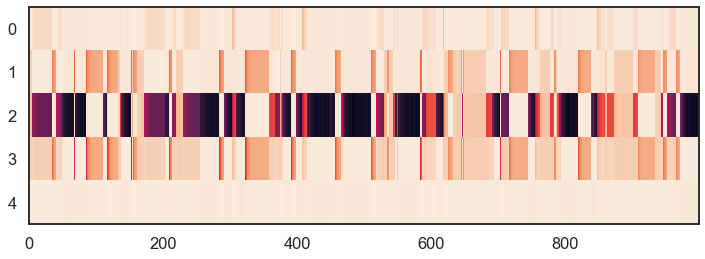

In [94]:
plt.figure(figsize=(12, 4))
plt.imshow(log_likes.T, aspect='auto')
plt.show()

In [101]:
print(harhmm_sem.log_likelihood(datas[i], inputs[i], masks[i], tags[i]))

pi0 = harhmm_sem.init_state_distn.initial_state_distn
Ps = harhmm_sem.transitions.transition_matrices(datas[i], inputs[i], masks[i], tags[i])
log_likes = harhmm_sem.observations.log_likelihoods(datas[i], inputs[i], masks[i], tags[i])

877.287435826185


In [84]:
pi0

array([1.37536227e-08, 3.85011011e-06, 1.25202079e-08, 5.14287887e-05,
       9.99944695e-01])

In [85]:
Ps

array([[[8.92125902e-01, 2.22787934e-16, 5.72485009e-02, 4.77737812e-02,
         2.85181627e-03],
        [2.89729844e-02, 8.96020398e-01, 1.41209227e-02, 4.04966781e-02,
         2.03890169e-02],
        [4.07469634e-02, 2.31649770e-13, 8.49853704e-01, 7.15497981e-02,
         3.78495348e-02],
        [4.57209954e-02, 3.03401109e-01, 2.27859694e-02, 6.28076692e-01,
         1.52337497e-05],
        [2.80747686e-02, 2.23999504e-02, 8.16210470e-02, 1.73594983e-02,
         8.50544736e-01]]])

In [86]:
log_likes

array([[-3.06293858e+00, -3.06293858e+00, -3.06293858e+00,
        -3.06293858e+00, -3.06293858e+00],
       [-1.64359147e+02, -3.77660531e+00, -1.81778787e+01,
        -1.01469007e+00, -1.55579638e+00],
       [-1.72611186e+02, -2.53277185e+00, -1.65332868e+01,
        -4.99356763e-01, -1.52293194e+00],
       ...,
       [ 2.83031669e+00, -1.78737538e+01, -1.02364776e+01,
        -1.14917503e+01, -4.81572801e+01],
       [-4.82313829e+02, -6.21001823e+02, -4.22930038e+00,
        -2.60089485e+01, -9.54477785e+00],
       [-4.51200742e+02, -5.03365706e+02, -1.24584397e+00,
        -1.99948683e+01, -5.00120811e+00]])

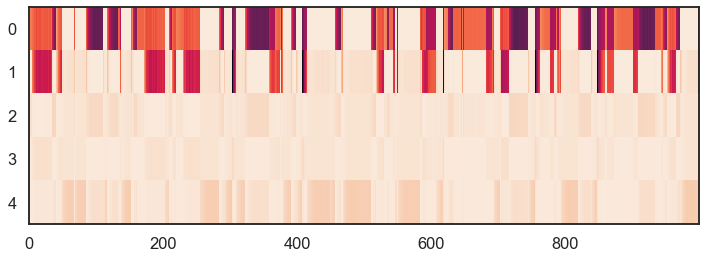

In [89]:
plt.figure(figsize=(12, 4))
plt.imshow(log_likes.T, aspect='auto')
plt.show()

In [98]:
harhmm_sem.log_prior()

12.781134127643185

# Compare true and inferred states

In [102]:
# Find a permutation of the states that best matches the true and inferred states
def align_states(inf_arhmm):
    most_likely_states = [inf_arhmm.most_likely_states(data, tag=tag) 
                          for data, tag in zip(datas, tags)]

    inf_arhmm.permute(find_permutation(np.concatenate(true_states), 
                                 np.concatenate(most_likely_states)))

    most_likely_states = [inf_arhmm.most_likely_states(data, tag=tag) 
                          for data, tag in zip(datas, tags)]

    expected_states = [inf_arhmm.expected_states(data, tag=tag)[0]
                       for data, tag in zip(datas, tags)]
    
    return most_likely_states, expected_states

reg_arhmm_states, reg_arhmm_expectations = align_states(reg_arhmm)
harhmm_states, harhmm_expectations = align_states(harhmm)
harhmm_sem_states, harhmm_sem_expectations = align_states(harhmm_sem)

In [103]:
def confusion_matrix(true_states, inf_states):
    confusion = np.zeros((num_states, num_states))
    for i in range(num_states):
        for j in range(num_states):
            for ztrue, zinf in zip(true_states, inf_states):
                confusion[i, j] += np.sum((ztrue == i) & (zinf == j))
    return confusion

reg_arhmm_confusion = confusion_matrix(true_states, reg_arhmm_states)

harhmm_confusions = []
for tag in unique_tags:
    harhmm_confusions.append(
        confusion_matrix(
            [z for z, t in zip(true_states, tags) if t == tag], 
            [z for z, t in zip(harhmm_states, tags) if t == tag]))
    
harhmm_sem_confusions = []
for tag in unique_tags:
    harhmm_sem_confusions.append(
        confusion_matrix(
            [z for z, t in zip(true_states, tags) if t == tag], 
            [z for z, t in zip(harhmm_sem_states, tags) if t == tag]))


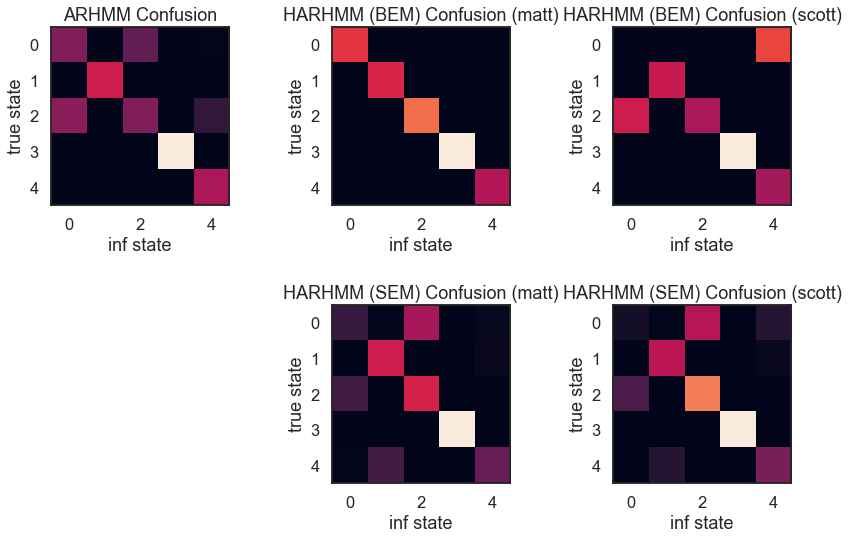

In [105]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

axs[0, 0].imshow(reg_arhmm_confusion)
axs[0, 0].set_xlabel("inf state")
axs[0, 0].set_ylabel("true state")
axs[0, 0].set_title("ARHMM Confusion")

for i, (tag, conf) in enumerate(zip(unique_tags, harhmm_confusions)):
    axs[0, i+1].imshow(conf)
    axs[0, i+1].set_xlabel("inf state")
    axs[0, i+1].set_ylabel("true state")
    axs[0, i+1].set_title("HARHMM (BEM) Confusion (" + tag + ")")

for i, (tag, conf) in enumerate(zip(unique_tags, harhmm_sem_confusions)):
    axs[1, i+1].imshow(conf)
    axs[1, i+1].set_xlabel("inf state")
    axs[1, i+1].set_ylabel("true state")
    axs[1, i+1].set_title("HARHMM (SEM) Confusion (" + tag + ")")
    
axs[1, 0].axis('off')

plt.tight_layout()

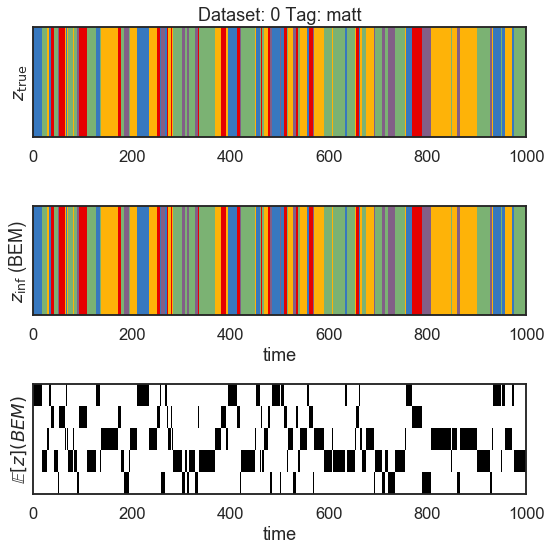

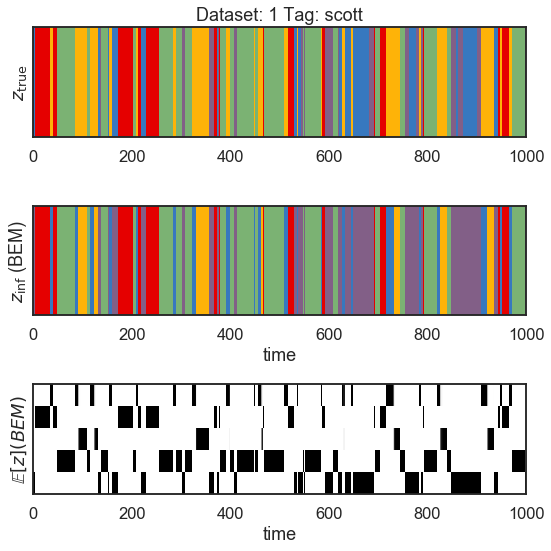

In [106]:
# Plot the true and inferred discrete states
for idx in range(2):
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    plt.imshow(true_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{true}}$")
    plt.yticks([])
    plt.title("Dataset: {} Tag: {}".format(idx, tags[idx]))

    plt.subplot(312)
    plt.imshow(harhmm_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{inf}}$ (BEM)")
    plt.yticks([])
    plt.xlabel("time")

    plt.subplot(313)
    plt.imshow(harhmm_expectations[idx].T, aspect="auto", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(0, time_bins)
    plt.ylabel("$\mathbb{E}[z] (BEM)$")
    plt.yticks([])
    plt.xlabel("time")

    plt.tight_layout()

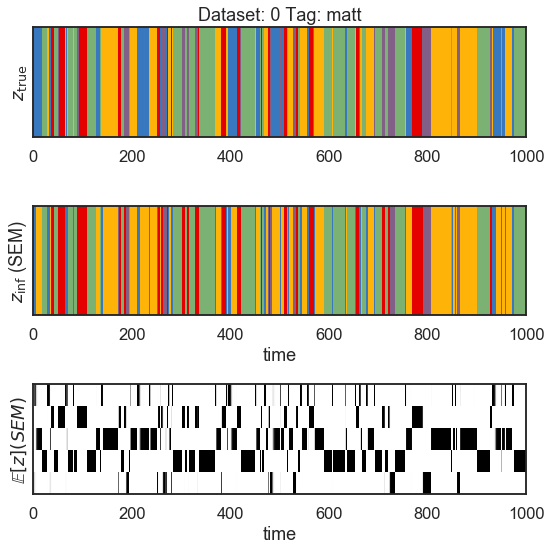

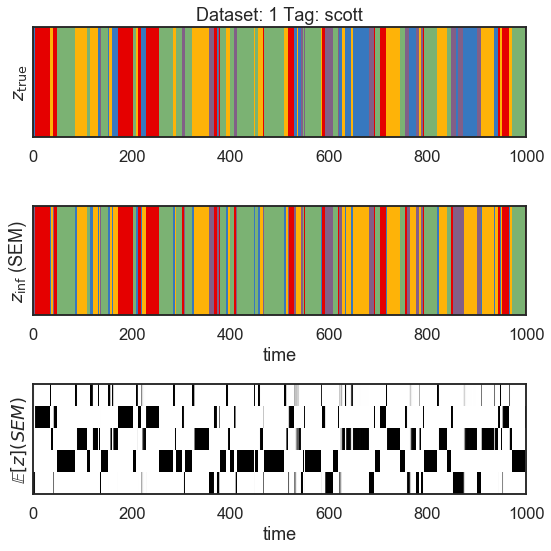

In [107]:
# Plot the true and inferred discrete states
for idx in range(2):
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    plt.imshow(true_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{true}}$")
    plt.yticks([])
    plt.title("Dataset: {} Tag: {}".format(idx, tags[idx]))

    plt.subplot(312)
    plt.imshow(harhmm_sem_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{inf}}$ (SEM)")
    plt.yticks([])
    plt.xlabel("time")

    plt.subplot(313)
    plt.imshow(harhmm_sem_expectations[idx].T, aspect="auto", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(0, time_bins)
    plt.ylabel("$\mathbb{E}[z] (SEM)$")
    plt.yticks([])
    plt.xlabel("time")

    plt.tight_layout()

# Plot the true and inferred dynamics

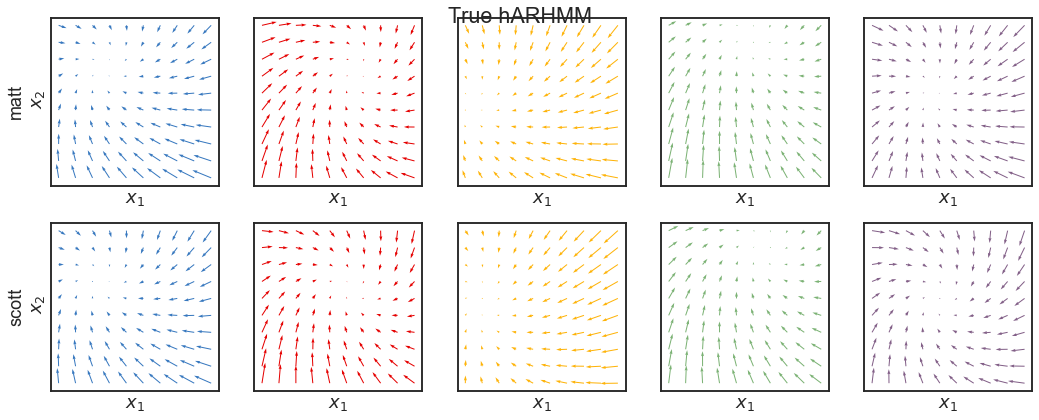

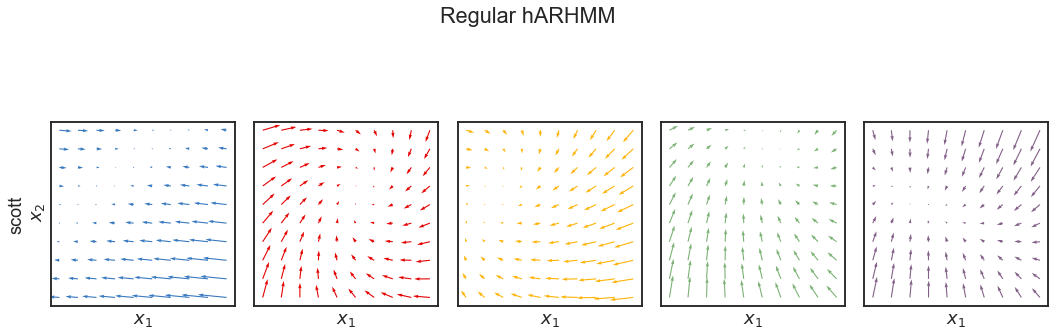

In [52]:
x = np.linspace(-8, 8, 10)
y = np.linspace(-8, 8, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

def plot_harhmm_dynamics(model, title):
    fig, axs = plt.subplots(len(unique_tags), num_states, figsize=(3 * num_states, 6))
    for i, tag in enumerate(unique_tags):
        for k, (A, b) in enumerate(zip(
            model.observations.per_group_ar_models[i].As, 
            model.observations.per_group_ar_models[i].bs)):

            dxydt_m = xy.dot(A.T) + b - xy
            axs[i, k].quiver(xy[:, 0], xy[:, 1],
                      dxydt_m[:, 0], dxydt_m[:, 1],
                      color=colors[k % len(colors)])


            axs[i,k].set_xlabel('$x_1$')
            axs[i,k].set_xticks([])
    #         axs[i,k].set_ylabel('$x_2$')
            if k == 0:
                axs[i,k].set_ylabel(tag + "\n $x_2$")
            axs[i,k].set_yticks([])
            axs[i,k].set_aspect("equal")
    fig.suptitle(title)                
    plt.tight_layout()
    
plot_harhmm_dynamics(true_harhmm, "True hARHMM")

def plot_arhmm_dynamics(model, title):
    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k, (A, b) in enumerate(zip(model.observations.As,
                                   model.observations.bs)):

        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                  dxydt_m[:, 0], dxydt_m[:, 1],
                  color=colors[k % len(colors)])


        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel(tag + "\n $x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
    fig.suptitle(title)                
    plt.tight_layout()
    
plot_arhmm_dynamics(reg_arhmm, "Regular hARHMM")


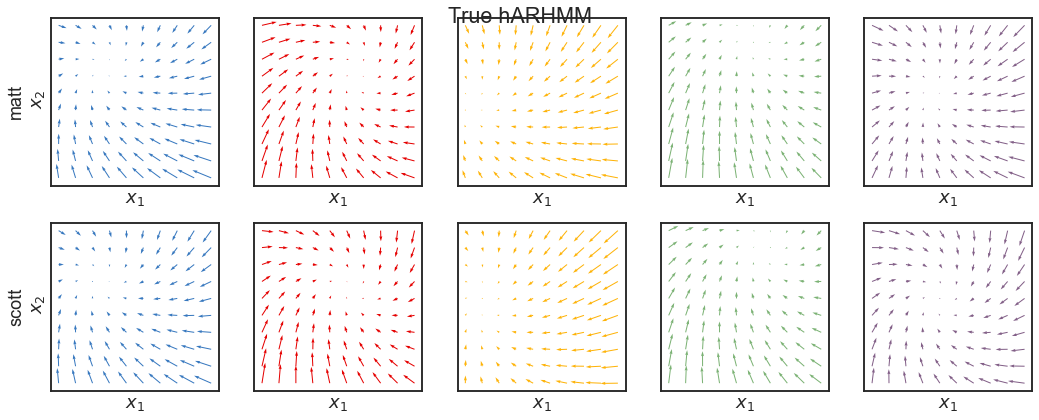

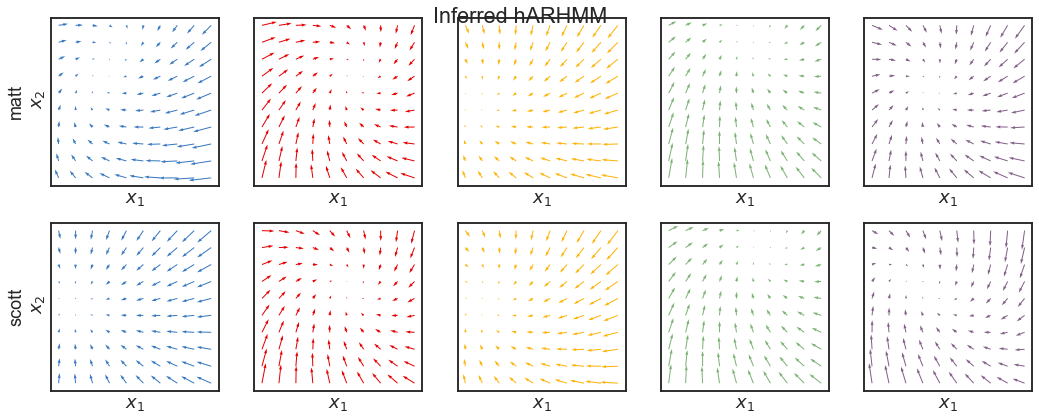

In [53]:
plot_harhmm_dynamics(true_harhmm, "True hARHMM")
plot_harhmm_dynamics(harhmm, "Inferred hARHMM (BEM)")

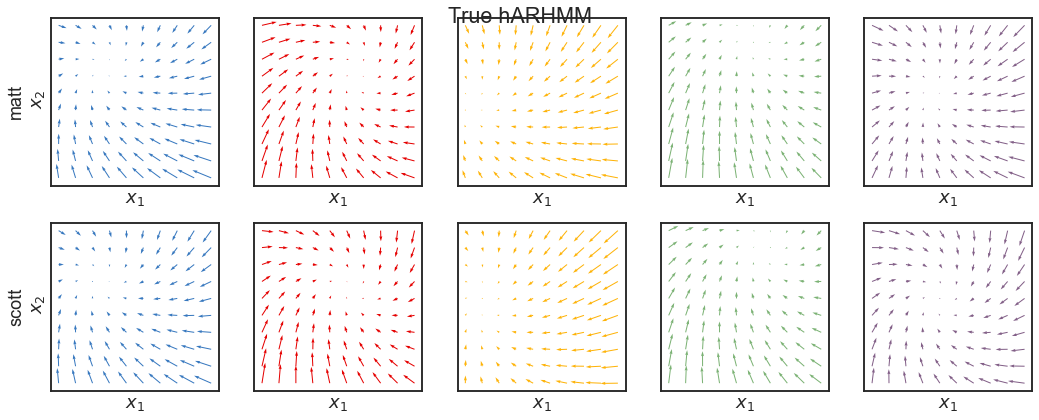

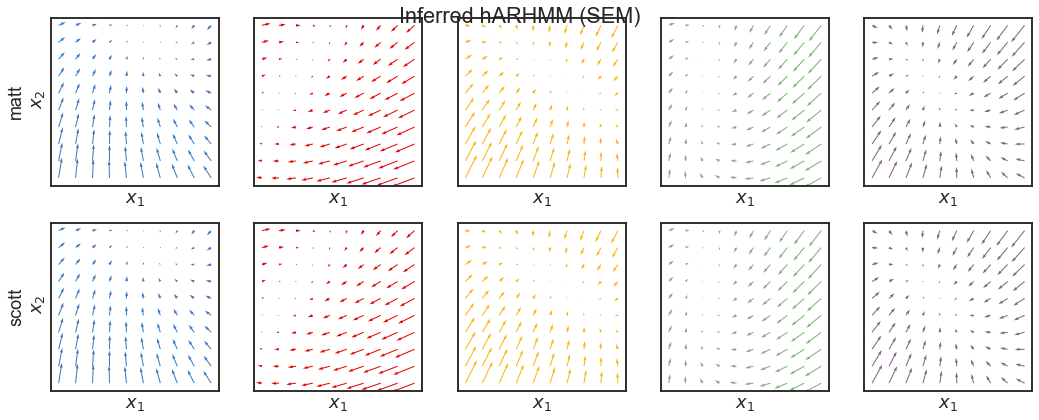

In [95]:
plot_harhmm_dynamics(true_harhmm, "True hARHMM")
plot_harhmm_dynamics(harhmm_sem, "Inferred hARHMM (SEM)")